# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [71]:
# CodeWrite 
# Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def calculate_kernel_matrix(X, kernel, kernel_param):
    """
    Calculate the kernel matrix for the data X
    """
    if(kernel == 'linear'):
        return np.matmul(X, X.T)
    elif(kernel == 'poly'):
        return (1 + np.matmul(X, X.T)) ** kernel_param
    elif(kernel == 'rbf'):
        return np.exp(-kernel_param * (np.sum(X ** 2, axis = 1) + np.sum(X ** 2, axis = 1)[:, np.newaxis] - 2 * np.matmul(X, X.T)))

def calculate_kernel_values(X, x, kernel, kernel_param):
    """
    Calculate the kernel values between x and all the points in X
    """
    if kernel == 'linear':
        return np.dot(X, x)
    elif kernel == 'poly':
        return (1 + np.dot(X, x)) ** kernel_param
    elif kernel == 'rbf':
        return np.exp(-kernel_param * np.sum((X - x) ** 2, axis=1))

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., kernel_param=1., num_iter_gd=100):
    """
    Arguments:
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = $\ lambda$
    num_iter_gd = number of GD iterations.

    Returns the result of kernel logistic regression :
    alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    Primal problem:
    $ \ min_w  \ sum_{i=1}^n \ log(1+\ exp(-y_i* \ w^\ top \phi(\ x_i)))  + \ frac{\ lambda}{2} ||\ w||^2 $

    the dual of which is

    $ \ min_alpha \ sum_{i=1}^n \ log(1+\ exp(-y_i* \ alpha^\ top K_{:,i} ))  + \ frac{\ lambda}{2} \ alpha^\ top K \ alpha $
    where $\ phi$ is the feature got by the kernel.

    Where K is the nxn kernel matrix computed on the training data.

    The kernel is defined by the kernel_param:
    If kernel=linear: K(\ u,\ v) = \ u^\ top \ v  
    If kernel=poly:  K(\ u,\ v) = (1+\ u^\ top \ v)^(kernel_param)
    If kernel=rbf:  K(\ u,\ v) = \ exp(-kernel_param*||\ u-\ v||^2)
    """
    kernel_X = calculate_kernel_matrix(X, kernel, kernel_param)
    alpha = np.zeros(X.shape[0])
    eta = 0.1
    
    for _ in range(num_iter_gd):
        delta_R_alpha = reg_param * np.matmul(kernel_X, alpha) - np.sum((1 - 1 / (1 + np.exp(-Y * np.matmul(kernel_X, alpha)))) * Y * kernel_X, axis=1)
        alpha = alpha - eta * delta_R_alpha
    
    return alpha

def test_pred(alpha, train_X, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    return np.array([np.sign(np.dot(alpha, calculate_kernel_values(train_X, test_X[i], kernel, kernel_param))) for i in range(test_X.shape[0])])

In [72]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below.

kernels = ['linear', 'poly', 'rbf']
num_iter = 100

best_kernel_params = {'A':{}, 'B':{}, 'C':{}, 'D':{}}
best_reg_params = {'A':{}, 'B':{}, 'C':{}, 'D':{}}

def find_best_parameter(kernel, X_train, Y_train, X_val, Y_val):
    best_kernel_param, best_reg_param, best_accuracy = 0, 0, 0
    kernel_params, reg_params = [], []

    if kernel == 'linear':
        kernel_params = [1]
        reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    elif kernel == 'poly':
        kernel_params = [1, 2, 4, 6, 8, 10]
        reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    elif kernel == 'rbf':
        kernel_params = [1e-3, 1e-2, 1e-1, 1, 2, 4, 10, 100]
        reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

    for kernel_param in kernel_params:
        for reg_param in reg_params:
            alpha = train_pred_logistic_regression(X_train, Y_train, kernel=kernel, reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=num_iter)
            pred = test_pred(alpha, X_train, X_val, kernel=kernel, kernel_param=kernel_param)
            pred[pred == 0] = 1
            accuracy = np.mean(pred == Y_val)
            if accuracy > best_accuracy:
                best_kernel_param, best_reg_param, best_accuracy = kernel_param, reg_param, accuracy
    return best_kernel_param, best_reg_param, best_accuracy

for a in ['A', 'B', 'C', 'D']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']

    X_train_full, Y_train_full = X_train, Y_train

    print("Dataset {}\n".format(a))
    X_train, X_val = X_train[:int(0.8 * X_train.shape[0])], X_train[int(0.8 * X_train.shape[0]):]
    Y_train, Y_val = Y_train[:int(0.8 * Y_train.shape[0])], Y_train[int(0.8 * Y_train.shape[0]):]

    for kernel in kernels:
        best_kernel_param, best_reg_param, best_accuracy = find_best_parameter(kernel, X_train, Y_train, X_val, Y_val)
        print("Kernel: {}, best_kernel_param: {}, best_reg_param: {}, best_val_accuracy: {}".format(kernel, best_kernel_param, best_reg_param, best_accuracy))
        alpha = train_pred_logistic_regression(X_train_full, Y_train_full, kernel, best_reg_param, best_kernel_param)
        best_kernel_params[a][kernel] = best_kernel_param
        best_reg_params[a][kernel] = best_reg_param
        train_pred = test_pred(alpha, X_train_full, X_train_full, kernel, best_kernel_param)
        train_pred[train_pred == 0] = 1
        train_accuracy = np.mean(train_pred == Y_train_full)
        print("Train accuracy: {}".format(train_accuracy))
        pred = test_pred(alpha, X_train_full, X_test, kernel, best_kernel_param)
        pred[pred == 0] = 1
        accuracy = np.mean(pred == Y_test)
        print("Test accuracy: {}\n".format(accuracy))

Dataset A

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.0001, best_val_accuracy: 0.88
Train accuracy: 0.828
Test accuracy: 0.842

Kernel: poly, best_kernel_param: 2, best_reg_param: 0.0001, best_val_accuracy: 0.8766666666666667
Train accuracy: 0.8693333333333333
Test accuracy: 0.844

Kernel: rbf, best_kernel_param: 1, best_reg_param: 1e-06, best_val_accuracy: 1.0
Train accuracy: 0.9986666666666667
Test accuracy: 0.994

Dataset B

Kernel: linear, best_kernel_param: 1, best_reg_param: 1e-06, best_val_accuracy: 0.74
Train accuracy: 0.7493333333333333
Test accuracy: 0.758

Kernel: poly, best_kernel_param: 4, best_reg_param: 0.0001, best_val_accuracy: 0.8366666666666667
Train accuracy: 0.824
Test accuracy: 0.806

Kernel: rbf, best_kernel_param: 2, best_reg_param: 1e-06, best_val_accuracy: 0.8366666666666667
Train accuracy: 0.7753333333333333
Test accuracy: 0.746

Dataset C

Kernel: linear, best_kernel_param: 1, best_reg_param: 1e-06, best_val_accuracy: 0.5033333333333333
Train ac

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic). 

### Best hyperparameters for each kernel type
- Used 20 % of training data as validation set
- KP - Kernel Parameter
- RP - Regularisation Parameter

| Dataset | Kernel | Best KP | Best RP | Train Accuracy | Test Accuracy |
|:-------:|:------:|:-------:|:-------:|:--------------:|:-------------:|
| A       | Linear | 1                  | 0.0001           | 0.828    | 0.842  |
| A       | Poly   | 2                  | 0.0001           | 0.8693   | 0.844  |
| A       | RBF    | 1                  | 1e-06            | 0.9986   | 0.994  |
| B       | Linear | 1                  | 1e-06            | 0.7493   | 0.758  |
| B       | Poly   | 4                  | 0.0001           | 0.824    | 0.806  |
| B       | RBF    | 2                  | 1e-06            | 0.7753   | 0.746  |
| C       | Linear | 1                  | 1e-06            | 0.5026   | 0.5117 |
| C       | Poly   | 1                  | 1e-06            | 0.5026   | 0.5117 |
| C       | RBF    | 0.1                | 1e-06            | 1.0      | 0.9696  |
| D       | Linear | 1                  | 1e-06            | 0.5675   | 0.7692  |
| D       | Poly   | 1                  | 1e-06            | 0.5675   | 0.7692  |
| D       | RBF    | 0.001              | 1e-06            | 0.9925   | 0.9053  |

### Best Kernel and its parameters for each dataset

| Dataset | Best Kernel | KP | RP |
|:-------:|:-----------:|:--:|:--:|
| A       | RBF         | 1  | 1e-06 |
| B       | RBF         | 2  | 1e-06 |
| C       | RBF         | 0.1 | 1e-06 |
| D       | RBF         | 0.001 | 1e-06 |


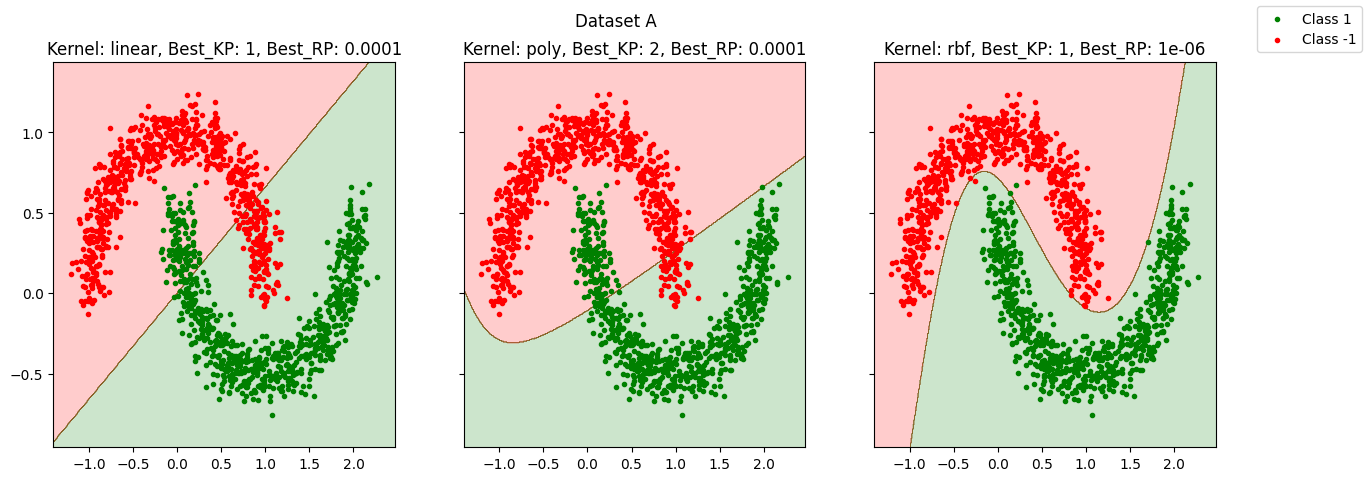

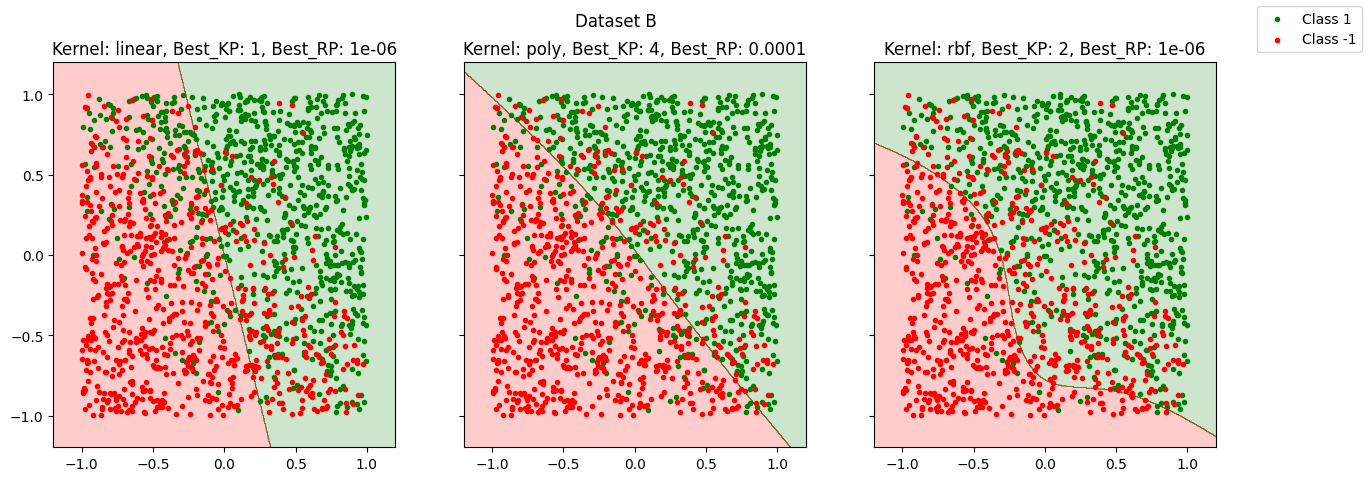

In [73]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

kernels = ['linear', 'poly', 'rbf']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    line = [0, 0]
    for i, kernel in enumerate(kernels):
        alpha = train_pred_logistic_regression(X_train, Y_train, kernel, best_reg_params[a][kernel], best_kernel_params[a][kernel])
        pred = test_pred(alpha, X_train, X_plotter, kernel, best_kernel_params[a][kernel])
        pred[pred == 0] = 1
        Z = pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title("Kernel: {}, Best_KP: {}, Best_RP: {}".format(kernel, best_kernel_params[a][kernel], best_reg_params[a][kernel]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle("Dataset {}".format(a))
    plt.show()


# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [74]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

def train_svm(X, Y, kernel='rbf', reg_param=1.0, kernel_param=1.0):
    """
    Train SVM classifier using sklearn.svm.SVC
    """
    clf = svm.SVC()
    if kernel == 'linear':
        clf = svm.SVC(kernel=kernel, C=reg_param)
    elif kernel == 'poly':
        clf = svm.SVC(kernel=kernel, degree=kernel_param, C=reg_param, coef0=1.0)
    elif kernel == 'rbf':
        clf = svm.SVC(kernel=kernel, gamma=kernel_param, C=reg_param)
    clf.fit(X, Y)
    return clf

def predict_value(clf, X):
    """
    Predict using the SVM classifier
    """
    return clf.predict(X)

In [75]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
    
kernels = ['linear', 'poly', 'rbf']

best_kernel_params = {'A': {}, 'B': {}, 'C': {}, 'D': {}}
best_reg_params = {'A': {}, 'B': {}, 'C': {}, 'D': {}}

def find_best_parameter(kernel, X_train, Y_train, X_val, Y_val):
    best_kernel_param, best_reg_param, best_accuracy = None, None, 0
    kernel_params, reg_params = [], []
    
    if kernel == 'linear':
        kernel_params = [1]
        reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    elif kernel == 'poly':
        kernel_params = [1, 2, 4, 6, 8]
        reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    elif kernel == 'rbf':
        kernel_params = [1e-3, 1e-2, 1e-1, 1, 2, 4, 10, 100]
        reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

    for kernel_param in kernel_params:
        for reg_param in reg_params:
            clf = train_svm(X_train, Y_train, kernel, reg_param=reg_param, kernel_param=kernel_param)
            pred = predict_value(clf, X_val)
            pred[pred == 0] = 1
            accuracy = np.mean(pred == Y_val)
            if accuracy > best_accuracy:
                best_kernel_param, best_reg_param, best_accuracy = kernel_param, reg_param, accuracy
    return best_kernel_param, best_reg_param, best_accuracy

for a in ['A', 'B', 'C', 'D']:
    dataset = "../../Data/dataset_" + a + ".npz"
    data = np.load(dataset)

    print("Dataset {}\n".format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']

    rand_indices = np.random.permutation(X_train.shape[0])
    X_train, X_val = X_train[rand_indices[:int(X_train.shape[0] * 0.8)]], X_train[rand_indices[int(X_train.shape[0] * 0.8):]]
    Y_train, Y_val = Y_train[rand_indices[:int(Y_train.shape[0] * 0.8)]], Y_train[rand_indices[int(Y_train.shape[0] * 0.8):]]

    for kernel in kernels:
        best_kernel_param, best_reg_param, best_accuracy = find_best_parameter(kernel, X_train, Y_train, X_val, Y_val)
        print("Kernel: {}, best_kernel_param: {}, best_reg_param: {}, val_accuracy: {}".format(kernel, best_kernel_param, best_reg_param, best_accuracy))
        clf = train_svm(X_train, Y_train, kernel=kernel, reg_param=best_reg_param, kernel_param=best_kernel_param)
        best_kernel_params[a][kernel] = best_kernel_param
        best_reg_params[a][kernel] = best_reg_param           
        pred = predict_value(clf, X_test)
        pred[pred == 0] = 1
        accuracy = np.mean(pred == Y_test)
        print("Test accuracy: {}\n".format(accuracy))

Dataset A

Kernel: linear, best_kernel_param: 1, best_reg_param: 1, val_accuracy: 0.8766666666666667
Test accuracy: 0.872

Kernel: poly, best_kernel_param: 4, best_reg_param: 0.1, val_accuracy: 1.0
Test accuracy: 0.998

Kernel: rbf, best_kernel_param: 0.1, best_reg_param: 100, val_accuracy: 1.0
Test accuracy: 0.996

Dataset B

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.01, val_accuracy: 0.85
Test accuracy: 0.814

Kernel: poly, best_kernel_param: 1, best_reg_param: 0.01, val_accuracy: 0.8466666666666667
Test accuracy: 0.802

Kernel: rbf, best_kernel_param: 0.001, best_reg_param: 10, val_accuracy: 0.85
Test accuracy: 0.804

Dataset C

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.1, val_accuracy: 0.9166666666666666
Test accuracy: 0.8821548821548821

Kernel: poly, best_kernel_param: 2, best_reg_param: 10, val_accuracy: 0.9933333333333333
Test accuracy: 0.9595959595959596

Kernel: rbf, best_kernel_param: 0.001, best_reg_param: 1, val_accuracy: 0.9966666666666667
Test

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  


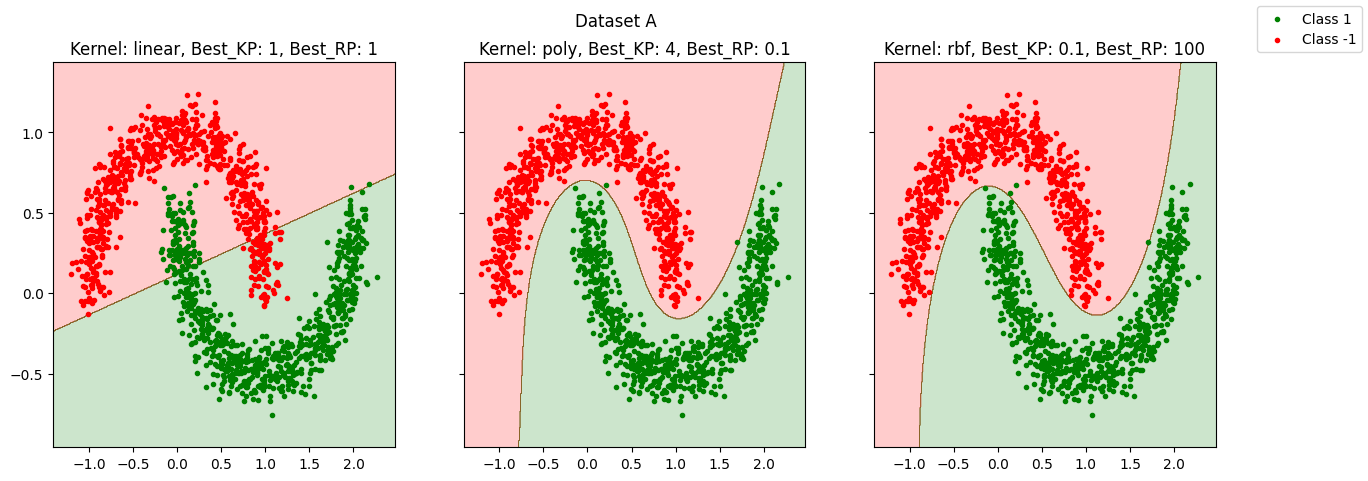

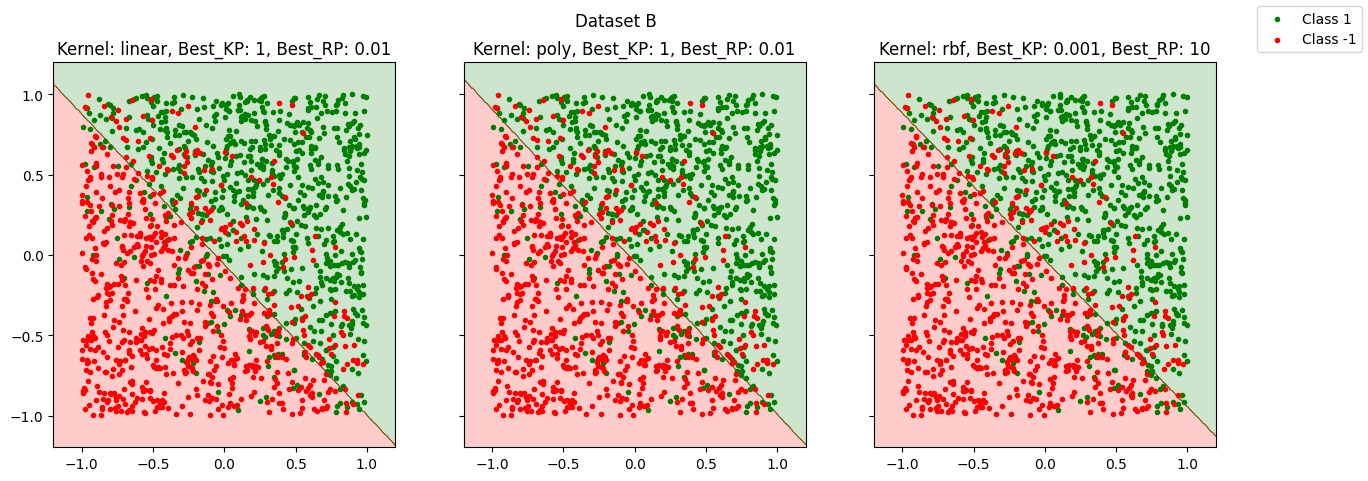

In [76]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

kernels = ['linear', 'poly', 'rbf']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    line = [0, 0]
    for i, kernel in enumerate(kernels):
        clf = train_svm(X_train, Y_train, kernel=kernel, reg_param=best_reg_params[a][kernel], kernel_param=best_kernel_params[a][kernel])
        pred = predict_value(clf, X_plotter)
        pred[pred == 0] = 1
        Z = pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title("Kernel: {}, Best_KP: {}, Best_RP: {}".format(kernel, best_kernel_params[a][kernel], best_reg_params[a][kernel]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle("Dataset {}".format(a))
    plt.show()

# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [77]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

def entropy(p):
    """
    Computes entropy of a probability distribution
    """
    if(p == 0 or p == 1):
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes entropy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_entropy, X_right_entropy = entropy(X_left_pos / X_left_count), entropy(X_right_pos / X_right_count)
    return (X_left_count * X_left_entropy + X_right_count * X_right_entropy) / (X_left_count + X_right_count)

def find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes accuracy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_neg, X_right_neg = X_left_count - X_left_pos, X_right_count - X_right_pos
    return max(X_left_pos + X_right_neg, X_left_neg + X_right_pos, X_left_pos + X_right_pos, X_left_neg + X_right_neg) / (X_left_count + X_right_count)

def find_best_attribute_threshold(X, Y, criterion):
    """
    Finds the best attribute and threshold to split based on the criterion
    """
    best_attribute, best_threshold = None, None
    best_accuracy, best_entropy = 0, np.inf

    for attribute in range(X.shape[1]):
        sorted_thresholds = np.sort(np.unique(X[:, attribute]))
        sorted_X, sorted_Y = np.sort(X[:, attribute]), Y[np.argsort(X[:, attribute])]
        X_left_count, X_right_count = 0, X.shape[0]
        X_left_pos, X_right_pos = 0, np.sum(sorted_Y == 1)

        for threshold in sorted_thresholds:
            while(X_left_count < X.shape[0] and sorted_X[X_left_count] <= threshold):
                if(sorted_Y[X_left_count] == 1):
                    X_left_pos, X_right_pos = X_left_pos + 1, X_right_pos - 1
                X_left_count, X_right_count = X_left_count + 1, X_right_count - 1

            if(criterion == 'entropy'):
                entropy = find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(entropy < best_entropy):
                    best_entropy, best_attribute, best_threshold = entropy, attribute, threshold

            elif(criterion == 'accuracy'):
                accuracy = find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(accuracy > best_accuracy):
                    best_accuracy, best_attribute, best_threshold = accuracy, attribute, threshold
    return best_attribute, best_threshold

class Node:
    """
    Node class for the decision tree
    """
    def __init__(self, attribute, type, value, threshold):
        self.attribute = attribute
        self.type = type # 0: leaf, 1: internal
        self.value = value # if leaf, value is the class label, else None
        self.threshold = threshold # if internal, threshold is the threshold, else None
        self.left, self.right = None, None

    def split_node(self, X, Y, criterion, num_nodes_stop):
        """
        Splits the node into two children nodes based on the best attribute and threshold
        """
        if(X.shape[0] <= num_nodes_stop):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self
        
        pos_count = np.sum(Y == 1)
        if(pos_count == 0 or pos_count == Y.shape[0]):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        self.type = 1
        self.attribute, self.threshold = find_best_attribute_threshold(X, Y, criterion)
        X_left, X_right = X[X[:, self.attribute] <= self.threshold], X[X[:, self.attribute] > self.threshold]
        Y_left, Y_right = Y[X[:, self.attribute] <= self.threshold], Y[X[:, self.attribute] > self.threshold]

        if(X_left.shape == X.shape or X_right.shape == X.shape):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        node_left, node_right = Node(None, None, None, None), Node(None, None, None, None)
        self.left = node_left.split_node(X_left, Y_left, criterion, num_nodes_stop)
        self.right = node_right.split_node(X_right, Y_right, criterion, num_nodes_stop)
        return self

    def predict(self, X):
        """
        Predicts the class label for a given example matrix
        """
        if(self.type == 0):
            return self.value
        else:
            return self.left.predict(X) if X[self.attribute] <= self.threshold else self.right.predict(X)

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(None, None, None, None)
    return root.split_node(X, Y, criterion, num_nodes_stop)

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return np.array([tree.predict(x) for x in test_X])

In [78]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.
# best_num_nodes is dict of dicts with dataset and criterion as keys and best num_nodes_stop as value

best_num_nodes = {'A': {}, 'B': {}, 'C': {}, 'D': {}}

for a in ['A', 'B', 'C', 'D']:
    data = np.load("../../Data/dataset_{}.npz".format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    print('Dataset {}'.format(a))

    X_train_full, Y_train_full = X_train, Y_train
    rand_perm = np.random.permutation(X_train.shape[0])
    X_train, X_val = X_train[rand_perm[:int(0.8 * X_train.shape[0])]], X_train[rand_perm[int(0.8 * X_train.shape[0]):]]
    Y_train, Y_val = Y_train[rand_perm[:int(0.8 * Y_train.shape[0])]], Y_train[rand_perm[int(0.8 * Y_train.shape[0]):]]

    num_nodes_stops = np.array(range(1, 41, 1))
    criterions = ['accuracy', 'entropy']
    for criterion in criterions:
        best_accuracy, best_num_nodes_stop = 0, 0
        for num_nodes_stop in num_nodes_stops:
            tree = train_decision_tree(X_train, Y_train, num_nodes_stop, criterion)
            Y_pred = eval_decision_tree(tree, X_val)
            accuracy = np.sum(Y_pred == Y_val) / Y_val.shape[0]
            if(accuracy > best_accuracy):
                best_accuracy, best_num_nodes_stop = accuracy, num_nodes_stop
        print('Best val_accuracy = {} with criterion = {} and num_nodes_stop = {}'.format(best_accuracy, criterion, best_num_nodes_stop))
        best_num_nodes[a][criterion] = best_num_nodes_stop
        best_tree = train_decision_tree(X_train_full, Y_train_full, best_num_nodes_stop, criterion)
        test_pred = eval_decision_tree(best_tree, X_test)
        test_accuracy = np.sum(test_pred == Y_test) / Y_test.shape[0]
        print('Test accuracy = {}'.format(test_accuracy))
    print()

Dataset A
Best val_accuracy = 0.9366666666666666 with criterion = accuracy and num_nodes_stop = 1
Test accuracy = 0.924
Best val_accuracy = 1.0 with criterion = entropy and num_nodes_stop = 1
Test accuracy = 0.99

Dataset B
Best val_accuracy = 0.7133333333333334 with criterion = accuracy and num_nodes_stop = 31
Test accuracy = 0.732
Best val_accuracy = 0.8 with criterion = entropy and num_nodes_stop = 35
Test accuracy = 0.774

Dataset C
Best val_accuracy = 0.8633333333333333 with criterion = accuracy and num_nodes_stop = 1
Test accuracy = 0.8417508417508418
Best val_accuracy = 0.9166666666666666 with criterion = entropy and num_nodes_stop = 3
Test accuracy = 0.8922558922558923

Dataset D
Best val_accuracy = 0.8875 with criterion = accuracy and num_nodes_stop = 1
Test accuracy = 0.8757396449704142
Best val_accuracy = 0.8625 with criterion = entropy and num_nodes_stop = 1
Test accuracy = 0.9053254437869822



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  



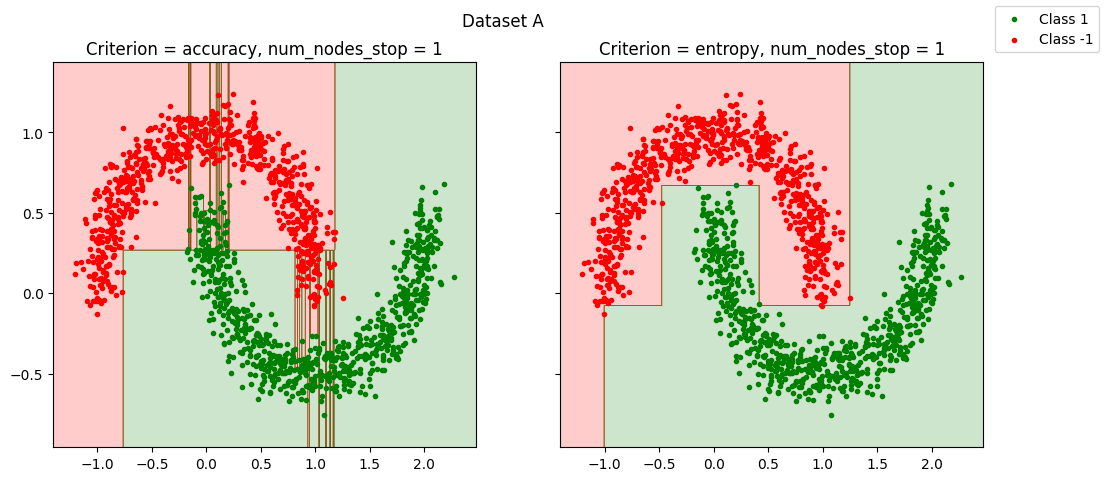

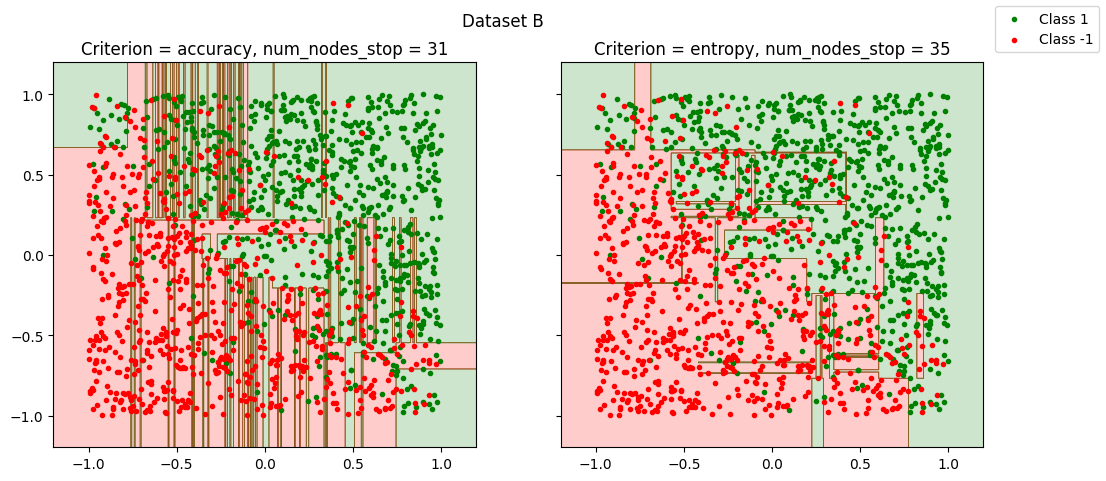

In [79]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

# this cell needs to be run after the cell above as it uses the best_num_nodes dict

criterions = ['accuracy', 'entropy']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
    line = [0, 0]
    for i, criterion in enumerate(criterions):
        tree = train_decision_tree(X_train, Y_train, best_num_nodes[a][criterion], criterion)
        Y_pred = eval_decision_tree(tree, X_plotter)
        Y_pred[Y_pred == 0] = 1
        Z = Y_pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title('Criterion = {}, num_nodes_stop = {}'.format(criterion, best_num_nodes[a][criterion]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle('Dataset {}'.format(a))
    plt.show()

# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [80]:
# CodeWrite cell
# Write Random Forest classifier. 

def entropy(p):
    """
    Computes entropy of a probability distribution
    """
    if(p == 0 or p == 1):
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes entropy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_entropy = entropy(X_left_pos / X_left_count)
    X_right_entropy = entropy(X_right_pos / X_right_count)
    tot_entropy = (X_left_count * X_left_entropy + X_right_count * X_right_entropy) / (X_left_count + X_right_count)
    return tot_entropy

def find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes accuracy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_neg = (X_left_count - X_left_pos)
    X_right_neg = (X_right_count - X_right_pos)
    total = X_left_count + X_right_count
    return max(X_left_pos + X_right_neg, X_left_neg + X_right_pos, X_left_pos + X_right_pos, X_left_neg + X_right_neg) / total

def find_best_attribute_threshold(X, Y, criterion, b=0.5):
    """
    Finds the best attribute and threshold to split based on the criterion
    """
    best_attribute, best_threshold = None, None
    best_accuracy, best_entropy = 0, np.inf
    
    attributes = np.random.choice(X.shape[1], int(b * X.shape[1]), replace=False)

    for attribute in attributes:
        sorted_thresholds = np.sort(np.unique(X[:, attribute]))
        sorted_X, sorted_Y = np.sort(X[:, attribute]), Y[np.argsort(X[:, attribute])]
        X_left_count, X_right_count = 0, X.shape[0]
        X_left_pos, X_right_pos = 0, np.sum(sorted_Y == 1)

        for threshold in sorted_thresholds:
            while(X_left_count < X.shape[0] and sorted_X[X_left_count] <= threshold):
                if(sorted_Y[X_left_count] == 1):
                    X_left_pos, X_right_pos = X_left_pos + 1, X_right_pos - 1
                X_left_count, X_right_count = X_left_count + 1, X_right_count - 1

            if(criterion == 'entropy'):
                entropy = find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(entropy < best_entropy):
                    best_entropy, best_attribute, best_threshold = entropy, attribute, threshold

            elif(criterion == 'accuracy'):
                accuracy = find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(accuracy > best_accuracy):
                    best_accuracy, best_attribute, best_threshold = accuracy, attribute, threshold
    return best_attribute, best_threshold

class Node:
    """
    Node class for the decision tree
    """
    def __init__(self, attribute, type, value, threshold):
        self.attribute = attribute
        self.type = type # 0: leaf, 1: internal
        self.value = value # if leaf, value is the class label, else None
        self.threshold = threshold # if internal, threshold is the threshold, else None
        self.left, self.right = None, None

    def split_node(self, X, Y, criterion, num_nodes_stop, b=0.5):
        """
        Splits the node into two children nodes based on the best attribute and threshold
        """
        if(X.shape[0] <= num_nodes_stop):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self
        
        pos_count = np.sum(Y == 1)
        if(pos_count == 0 or pos_count == Y.shape[0]):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        self.type = 1
        self.attribute, self.threshold = find_best_attribute_threshold(X, Y, criterion, b)
        X_left, X_right = X[X[:, self.attribute] <= self.threshold], X[X[:, self.attribute] > self.threshold]
        Y_left, Y_right = Y[X[:, self.attribute] <= self.threshold], Y[X[:, self.attribute] > self.threshold]

        if(X_left.shape == X.shape or X_right.shape == X.shape):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        node_left, node_right = Node(None, None, None, None), Node(None, None, None, None)
        self.left = node_left.split_node(X_left, Y_left, criterion, num_nodes_stop, b)
        self.right = node_right.split_node(X_right, Y_right, criterion, num_nodes_stop, b)
        return self

    def predict(self, X):
        """
        Predicts the class label for a given example matrix
        """
        if(self.type == 0):
            return self.value
        else:
            return self.left.predict(X) if X[self.attribute] <= self.threshold else self.right.predict(X)

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy', b=0.5):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(None, None, None, None)
    return root.split_node(X, Y, criterion, num_nodes_stop, b)

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return np.array([tree.predict(x) for x in test_X])

class Forest:
    def __init__(self):
        self.trees = []
    
    def add_tree(self, tree):
        self.trees.append(tree)
    
    def predict_values(self, X):
        predictions = np.array([eval_decision_tree(tree, X) for tree in self.trees])
        return np.sign(np.sum(predictions, axis=0))

def resample(X, Y, percent):
    """
    Returns a resampled dataset of size a from the given dataset
    """
    indices = np.random.choice(X.shape[0], int(percent * X.shape[0]), replace=True)
    return X[indices], Y[indices]

def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, criterion='accuracy', a=0.5, b=0.5):
    """ 
    Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    forest = Forest()
    for _ in range(num_trees):
        X_train, Y_train = resample(X, Y, a)
        tree = train_decision_tree(X_train, Y_train, num_nodes_stop, criterion, b)
        forest.add_tree(tree)
    return forest

def eval_random_forest(random_forest, test_X):
    """ 
    Takes in a  random forest object (however you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return random_forest.predict_values(test_X)

In [81]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

num_trees = [1, 5, 10, 20, 50, 100, 200, 250, 500]
criterions = ['accuracy', 'entropy']

best_num_trees = {'A':{}, 'B':{}, 'C':{}, 'D':{}}

def find_best_hyperparameters(X, Y, criterion, num_nodes_stop=1, a=0.5, b=0.5):
    """
    Returns the best hyperparameters for the given criterion
    """
    best_num_tree = None
    best_accuracy = 0
    rand_perm = np.random.permutation(X.shape[0])
    X_train, Y_train = X[rand_perm[:int(0.8 * X.shape[0])]], Y[rand_perm[:int(0.8 * X.shape[0])]]
    X_val, Y_val = X[rand_perm[int(0.8 * X.shape[0]):]], Y[rand_perm[int(0.8 * X.shape[0]):]]
    for num_tree in num_trees:
        forest = train_random_forest(X_train, Y_train, num_tree, num_nodes_stop, criterion, a, b)
        predictions = eval_random_forest(forest, X_val)
        accuracy = np.sum(predictions == Y_val) / Y_val.shape[0]
        if(accuracy > best_accuracy):
            best_accuracy, best_num_tree = accuracy, num_tree
    return best_num_tree, best_accuracy

for a in ['A', 'B', 'C', 'D']:
    print(f"Dataset {a}")
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    for criterion in criterions:
        print(f"Criterion: {criterion}")
        num_tree, accuracy = find_best_hyperparameters(X_train, Y_train, criterion)
        best_num_trees[a][criterion] = num_tree
        print(f"Best number of trees: {num_tree}")
        print(f"Best Validation Accuracy: {accuracy}")
        forest = train_random_forest(X_train, Y_train, num_tree, 1, criterion)
        predictions = eval_random_forest(forest, X_test)
        predictions_train = eval_random_forest(forest, X_train)
        print(f"Train Accuracy: {np.sum(predictions_train == Y_train) / Y_train.shape[0]}")
        print(f"Test Accuracy: {np.sum(predictions == Y_test) / Y_test.shape[0]}")
        print()

Dataset A
Criterion: accuracy
Best number of trees: 1
Best Validation Accuracy: 0.97
Train Accuracy: 0.9573333333333334
Test Accuracy: 0.934

Criterion: entropy
Best number of trees: 50
Best Validation Accuracy: 1.0
Train Accuracy: 0.998
Test Accuracy: 0.99

Dataset B
Criterion: accuracy
Best number of trees: 50
Best Validation Accuracy: 0.8333333333333334
Train Accuracy: 0.9426666666666667
Test Accuracy: 0.774

Criterion: entropy
Best number of trees: 100
Best Validation Accuracy: 0.7933333333333333
Train Accuracy: 0.9446666666666667
Test Accuracy: 0.772

Dataset C
Criterion: accuracy
Best number of trees: 50
Best Validation Accuracy: 0.9566666666666667
Train Accuracy: 0.9693333333333334
Test Accuracy: 0.9326599326599326

Criterion: entropy
Best number of trees: 100
Best Validation Accuracy: 0.9833333333333333
Train Accuracy: 0.9986666666666667
Test Accuracy: 0.9528619528619529

Dataset D
Criterion: accuracy
Best number of trees: 50
Best Validation Accuracy: 0.95
Train Accuracy: 0.985

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  


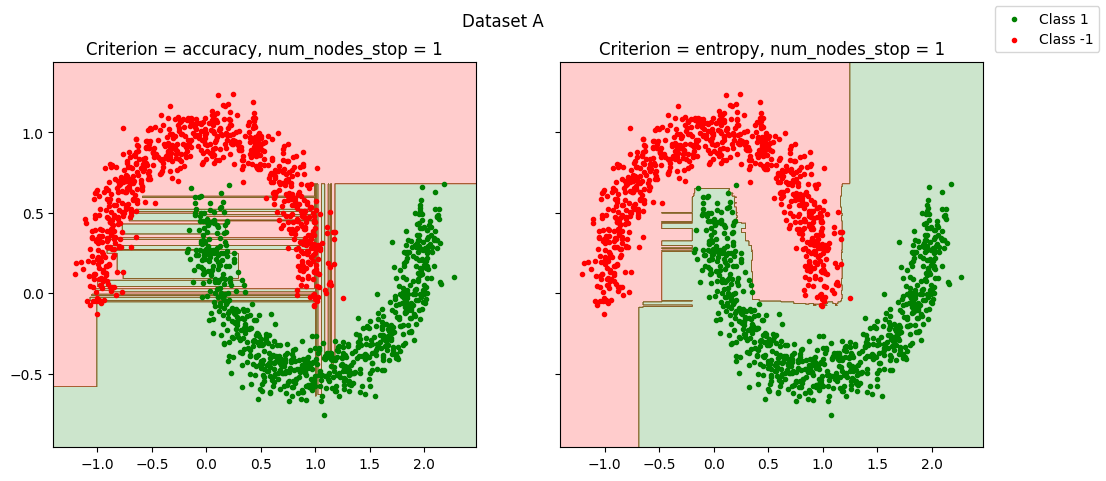

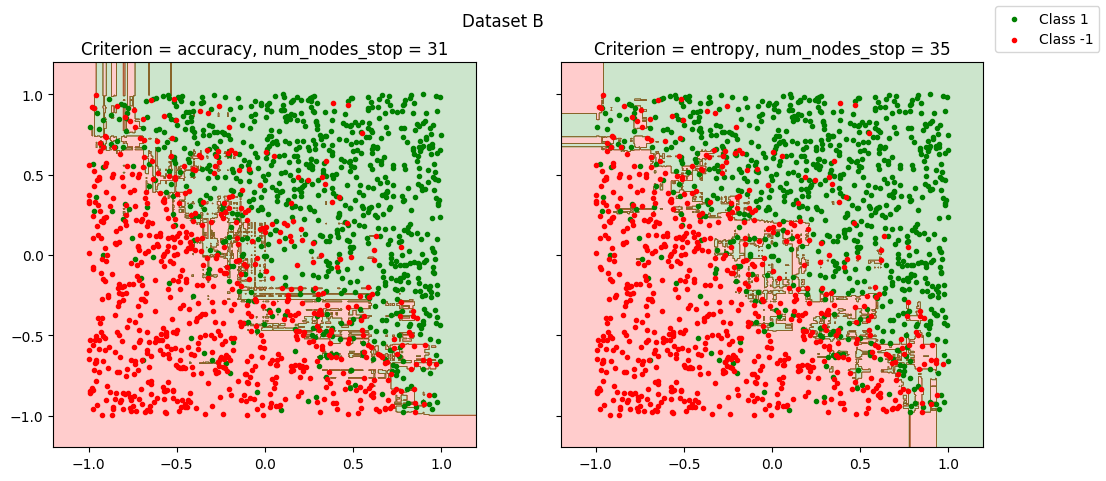

In [82]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

criterions = ['accuracy', 'entropy']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
    line = [0, 0]
    for i, criterion in enumerate(criterions):
        forest = train_random_forest(X_train, Y_train, best_num_trees[a][criterion], 1, criterion)
        Y_pred = eval_random_forest(forest, X_plotter)
        Y_pred[Y_pred == 0] = 1
        Z = Y_pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title('Criterion = {}, num_nodes_stop = {}'.format(criterion, best_num_nodes[a][criterion]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle('Dataset {}'.format(a))
    plt.show()
        

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [83]:
# Codewrite cell
# Write code to run here (no plotting)

def find_accuracy(X_left_weight, X_right_weight, X_left_pos, X_right_pos, X_left_neg, X_right_neg):
    """
    Computes accuracy of a split using the weights of positive and negative 
    examples in the left and right side of the split
    """
    return max(X_left_pos + X_right_neg, X_left_neg + X_right_pos, X_left_pos + X_right_pos, X_left_neg + X_right_neg) / (X_left_weight + X_right_weight)

def find_best_attribute_threshold(X, Y, weights):
    """
    Finds the best attribute and threshold to split
    """
    best_attribute, best_threshold = None, None
    best_accuracy = 0

    for attribute in range(X.shape[1]):
        sorted_thresholds = np.sort(np.unique(X[:, attribute]))
        sorted_X, sorted_Y, sorted_weights = np.sort(X[:, attribute]), Y[np.argsort(X[:, attribute])], weights[np.argsort(X[:, attribute])]
        X_left_count, X_right_count = 0, sorted_X.shape[0]
        X_left_weight, X_right_weight = 0, np.sum(sorted_weights)
        X_left_pos, X_right_pos = 0, np.sum(sorted_weights[sorted_Y == 1])
        X_left_neg, X_right_neg = 0, np.sum(sorted_weights[sorted_Y == -1])

        for threshold in sorted_thresholds:
            while(X_left_count < X.shape[0] and sorted_X[X_left_count] <= threshold):
                if(sorted_Y[X_left_count] == 1):
                    X_left_pos, X_right_pos = X_left_pos + sorted_weights[X_left_count], X_right_pos - sorted_weights[X_left_count]
                else:
                    X_left_neg, X_right_neg = X_left_neg + sorted_weights[X_left_count], X_right_neg - sorted_weights[X_left_count]
                X_left_weight, X_right_weight = X_left_weight + sorted_weights[X_left_count], X_right_weight - sorted_weights[X_left_count]
                X_left_count, X_right_count = X_left_count + 1, X_right_count - 1

            accuracy = find_accuracy(X_left_weight, X_right_weight, X_left_pos, X_right_pos, X_left_neg, X_right_neg)
            if(accuracy > best_accuracy):
                best_accuracy, best_attribute, best_threshold = accuracy, attribute, threshold
    return best_attribute, best_threshold

class Node:
    """
    Node class for the decision tree
    """
    def __init__(self, attribute, type, value, threshold):
        self.attribute = attribute
        self.type = type # 0: leaf, 1: internal
        self.value = value # if leaf, value is the class label, else None
        self.threshold = threshold # if internal, threshold is the threshold, else None
        self.left, self.right = None, None

    def split_node(self, X, Y, weights, max_depth, num_nodes_stop):
        """
        Splits the node into two children nodes based on the best attribute and threshold
        """
        if(X.shape[0] <= num_nodes_stop or max_depth <= 0):
            self.type = 0
            self.value = 1 if np.sum(weights[Y == 1]) > np.sum(weights[Y == -1]) else -1
            return self
        
        pos_count = np.sum(Y == 1)
        if(pos_count == 0 or pos_count == Y.shape[0]):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        self.type = 1
        self.attribute, self.threshold = find_best_attribute_threshold(X, Y, weights)
        X_left, X_right = X[X[:, self.attribute] <= self.threshold], X[X[:, self.attribute] > self.threshold]
        Y_left, Y_right = Y[X[:, self.attribute] <= self.threshold], Y[X[:, self.attribute] > self.threshold]
        weights_left, weights_right = weights[X[:, self.attribute] <= self.threshold], weights[X[:, self.attribute] > self.threshold]

        if(X_left.shape == X.shape or X_right.shape == X.shape):
            self.type = 0
            self.value = 1 if np.sum(weights[Y == 1]) > np.sum(weights[Y == -1]) else -1
            return self

        node_left, node_right = Node(None, None, None, None), Node(None, None, None, None)
        self.left = node_left.split_node(X_left, Y_left, weights_left, num_nodes_stop, max_depth - 1)
        self.right = node_right.split_node(X_right, Y_right, weights_right, num_nodes_stop, max_depth - 1)
        return self

    def predict(self, X):
        """
        Predicts the class label for a given example matrix
        """
        if(self.type == 0):
            return self.value
        else:
            return self.left.predict(X) if X[self.attribute] <= self.threshold else self.right.predict(X)

def train_decision_tree(X, Y, weights, max_depth, num_nodes_stop):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(None, None, None, None)
    return root.split_node(X, Y, weights, max_depth, num_nodes_stop)

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return np.array([tree.predict(x) for x in test_X])

def Adaboost_train(X_train, Y_train, max_depth, num_iter, num_nodes_stop):
    """
    Trains a decision tree using Adaboost
    """
    trees, betas, train_accuracies, test_accuracies = [], [], [], []
    weights = np.ones(X_train.shape[0])
    for _ in range(num_iter):
        tree = train_decision_tree(X_train, Y_train, weights, max_depth, num_nodes_stop)
        predictions = eval_decision_tree(tree, X_train)
        trees = trees + [tree]
        error = np.sum(weights[predictions != Y_train]) / np.sum(weights)
        beta = (1-error)/error
        betas = betas + [beta]
        predictions_train = Adaboost_eval(trees, betas, X_train)
        train_accuracy = np.sum(predictions_train == Y_train) / Y_train.shape[0]
        predictions_test = Adaboost_eval(trees, betas, X_test)
        test_accuracy = np.sum(predictions_test == Y_test) / Y_test.shape[0]
        weights = weights * np.power(beta, predictions != Y_train)
        train_accuracies = train_accuracies + [train_accuracy]
        test_accuracies = test_accuracies + [test_accuracy]
    return trees, betas, train_accuracies, test_accuracies

def Adaboost_eval(trees, betas, X_test):
    """
    Evaluates the Adaboost model on the test data
    """
    Y_pred = np.zeros(X_test.shape[0])
    for i in range(len(trees)):
        Y_pred += np.log2(betas[i]) * eval_decision_tree(trees[i], X_test)
    return np.sign(Y_pred)

Dataset:  A


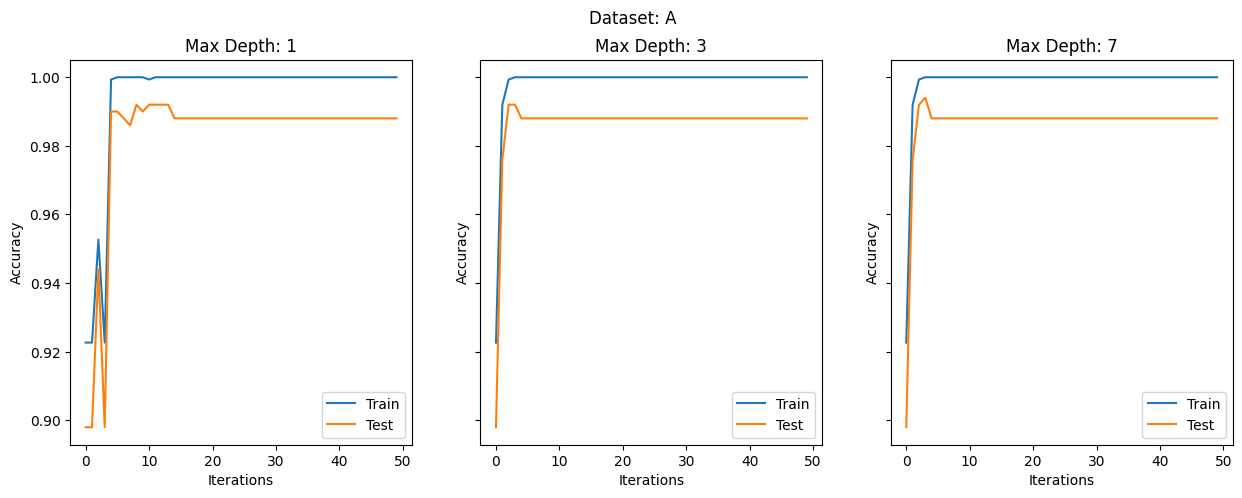

Dataset:  B


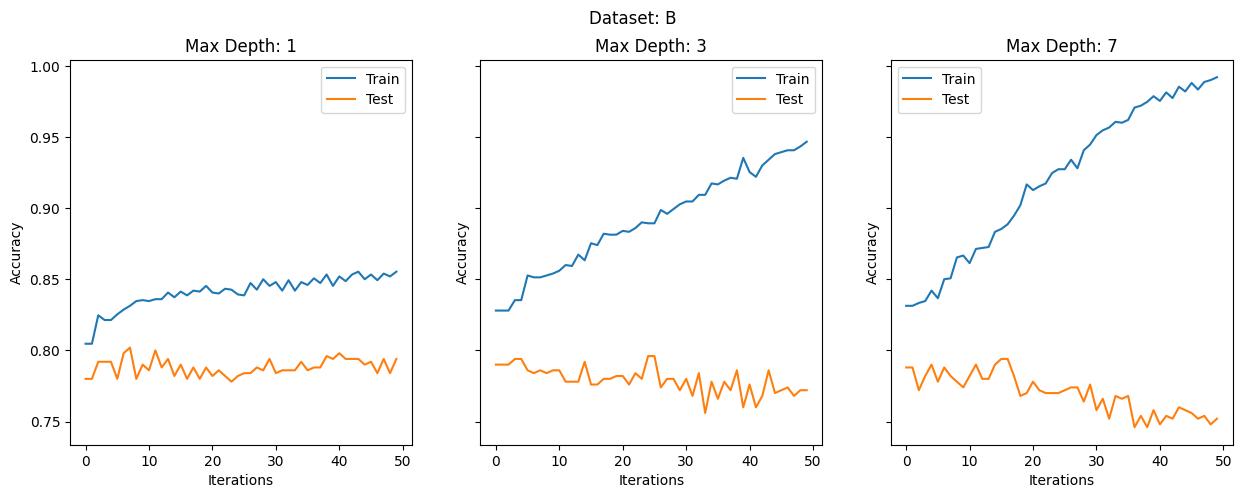

Dataset:  C


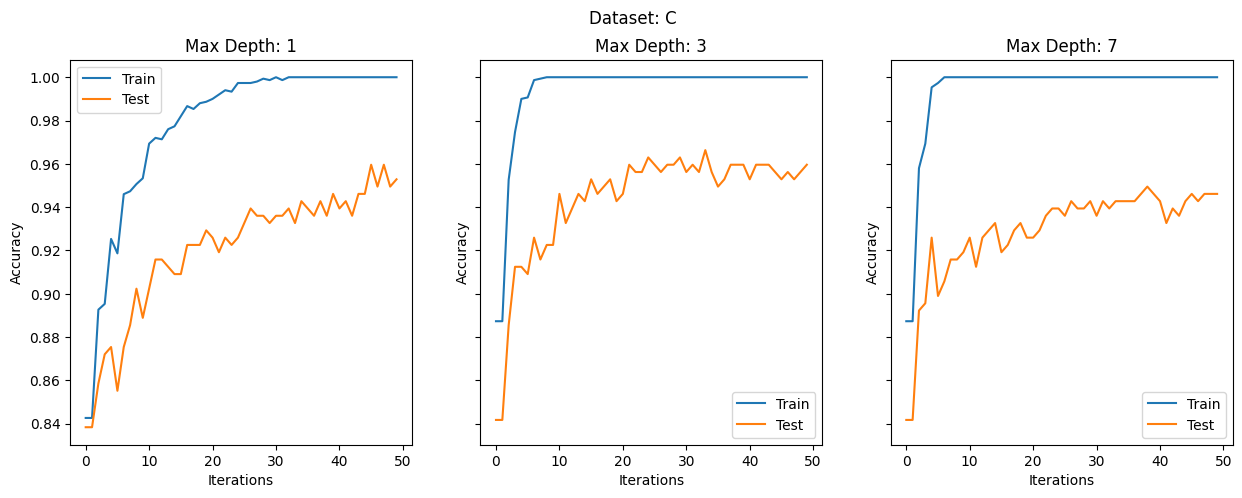

Dataset:  D


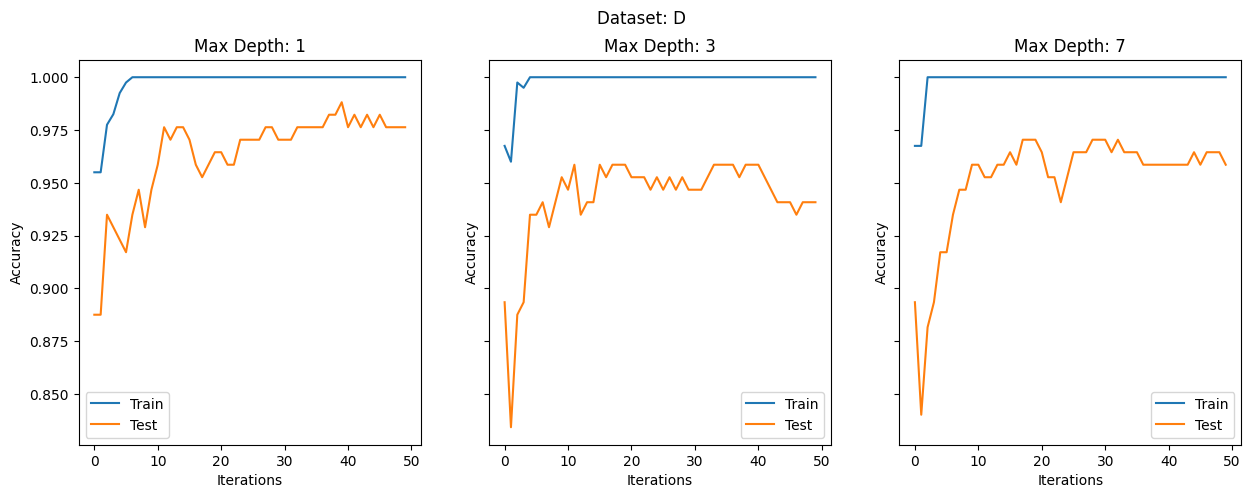

In [84]:
# Codewrite cell 
# Plots for iteration vs error here

max_depths = [1, 3, 7]

for a in ['A', 'B', 'C', 'D']:
    print("Dataset: ", a)
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i, max_depth in enumerate(max_depths):
        trees, betas, train_accuracies, test_accuracies = Adaboost_train(X_train, Y_train, max_depth, 50, int(0.1 * X_train.shape[0]))
        ax[i].plot(train_accuracies, label='Train')
        ax[i].plot(test_accuracies, label='Test')
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel('Accuracy')
        ax[i].set_title("Max Depth: {}".format(max_depth))
        ax[i].legend(loc='best')
    fig.suptitle("Dataset: {}".format(a))
    plt.show()

In [85]:
# Codewrite cell 
# Plots for illustrating the classifier here

def plot_adaboost_accuracy(X_train, Y_train, max_depth, num_iter, num_nodes_stop):
    """
    Plots the accuracy of the Adaboost model on the test set
    """
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    trees, betas, accuracies = Adaboost_train(X_train, Y_train, max_depth, num_iter, num_nodes_stop)
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]
    Y_pred = Adaboost_eval(trees, betas, X_plotter)
    plt.contourf(X, Y, Y_pred.reshape(X.shape), colors=['red', 'green'], alpha=0.2)
    plt.scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
    plt.scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
    plt.show()

Textwrite cell: